In [1]:
from tensorflow.keras.datasets.mnist import load_data

(X_train,y_train) , (X_test,y_test) =load_data()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
(60000,)


In [2]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K 

inp = Input(shape=(28,28,1))

x = Conv2D(filters=8 ,kernel_size=3, activation='relu')(inp)
x = MaxPooling2D(pool_size= (2,2))(x)

x =Flatten()(x)
x =Dense(units = 32,activation='relu')(x)
x = Dense(units =2)(x)

cnn = Model(inputs = inp , outputs = x )


img1 =Input(shape=(28,28,1))
img2 = Input(shape=(28,28,1))

f1 = cnn(img1)
f2 = cnn(img2)

d = K.sqrt(K.sum(K.square(f1-f2),axis =1 ,keepdims=True))

model = Model(inputs = (img1,img2),outputs = d)
model.summary()
cnn.summary()

def loss(y_true,y_pred):
    proba = K.exp(-K.square(y_pred))
    return -K.mean(y_true*K.log(proba)+(1-y_true)*K.log(1-proba))

def loss1(y_true,y_pred):
    return K.mean(y_true*K.square(y_pred)+(1-y_true)*K.square(K.maximum(1.0-y_pred,0)))

model.compile(optimizer='adam',loss = loss1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 2)            43442       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 2)            0           ['model[0][0]',            

Make all pairs or other strategies ; some innovation here

In [3]:
import numpy as np 
from matplotlib import pyplot as plt
def generator(X,y,k=8):
    unique_labels = np.unique(y)
    while True:
        X1 = []
        X2 = []
        y_batch = []
        for label in unique_labels :
            label_idx = np.where(y==label)[0]
            other_labels =set(unique_labels)-{label}
            for i in range(k):
                i1 = np.random.choice(label_idx)
                i2 = np.random.choice(label_idx)
                # i1 must be different from i2
                
                while i1 == i2 :
                    #i1 = np.random.choice(label_idx)
                    i2 = np.random.choice(label_idx)
                    
                # create positive example 
                X1.append(X[i1][:,:,None])
                X2.append(X[i2][:,:,None])
                y_batch.append(1.0)
                
                # create negative example
                i1 = np.random.choice(label_idx)
                my_label = np.random.choice(list(other_labels))
                i2 = np.random.choice(list(np.where(y == my_label)[0]))
                X1.append(X[i1][:,:,None])
                X2.append(X[i2][:,:,None])
                y_batch.append(0.0)
        
        yield [np.array(X1)/255.,np.array(X2)/255.],np.array(y_batch) 
            
                
                    
                    
                    

Batch size :  160
(28, 28, 1)
Pair label :  0.0


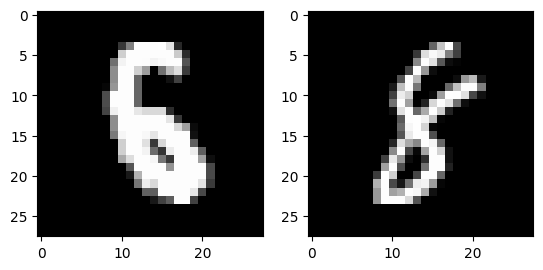

In [4]:
#for testing 
for pair,y in generator(X_test,y_test):
  print('Batch size : ',len(y))
  idx = np.random.choice(range(len(y)))
  print(pair[0][idx].shape)
  print('Pair label : ',y[idx])
  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(28,28),cmap='gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(28,28),cmap = 'gray')
  break

**Fit model**

In [5]:
history = model.fit(generator(X_train,y_train,k=32),
                    steps_per_epoch = 5,
                    epochs = 50,
                    validation_data = generator(X_test,y_test,k=8),
                    validation_steps= 5)

Epoch 1/50
5/5 [==============================] - 5s 660ms/step - loss: 0.2656 - val_loss: 0.2278
Epoch 2/50
5/5 [==============================] - 3s 646ms/step - loss: 0.1973 - val_loss: 0.1835
Epoch 3/50
5/5 [==============================] - 4s 848ms/step - loss: 0.1818 - val_loss: 0.1775
Epoch 4/50
5/5 [==============================] - 3s 586ms/step - loss: 0.1643 - val_loss: 0.1688
Epoch 5/50
5/5 [==============================] - 3s 597ms/step - loss: 0.1589 - val_loss: 0.1603
Epoch 6/50
5/5 [==============================] - 3s 607ms/step - loss: 0.1463 - val_loss: 0.1411
Epoch 7/50
5/5 [==============================] - 4s 839ms/step - loss: 0.1461 - val_loss: 0.1526
Epoch 8/50
5/5 [==============================] - 3s 613ms/step - loss: 0.1435 - val_loss: 0.1382
Epoch 9/50
5/5 [==============================] - 3s 662ms/step - loss: 0.1430 - val_loss: 0.1353
Epoch 10/50
5/5 [==============================] - 3s 665ms/step - loss: 0.1351 - val_loss: 0.1315
Epoch 11/50
5/5 [==

Visualize learning process

Text(0, 0.5, 'Loss')

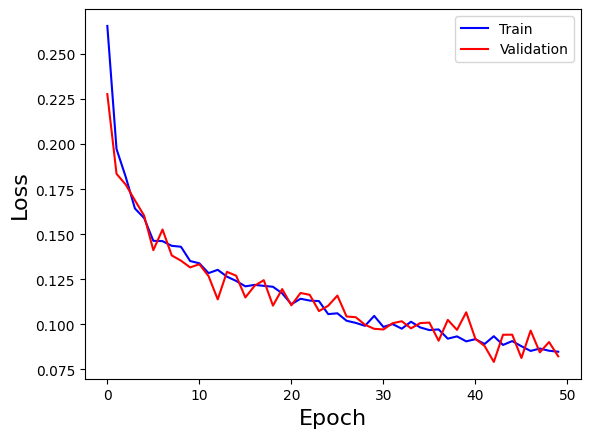

In [6]:
plt.plot(history.history['loss'],label='Train',c = 'b')
plt.plot(history.history['val_loss'],label='Validation',c = 'r')
plt.legend()
plt.xlabel('Epoch',fontsize = 16)
plt.ylabel('Loss',fontsize = 16)

5/5 [==============================] - 0s 7ms/step
Batch_size 160
Pair label :  1.0
Distance:  [0.20729025]
Distance by features :  [0.20729022]


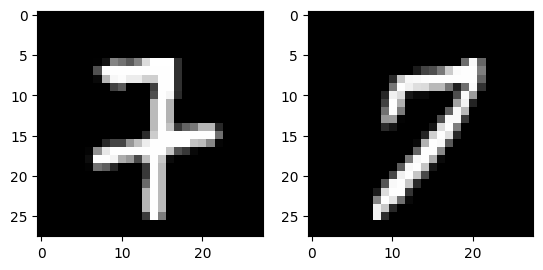

In [12]:
for pair,y in generator(X_test,y_test):
  y_pred = model.predict(pair)
  print('Batch_size',len(y))
  idx = np.random.choice(range(len(y)))
  print('Pair label : ',y[idx])
  print('Distance: ',y_pred[idx])
  f1 = cnn(pair[0])
  f2 = cnn(pair[1])
  d = np.sqrt(np.sum((f1-f2)**2,axis = 1,keepdims=True))
  print("Distance by features : ",d[idx])

  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(28,28),cmap='gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(28,28),cmap = 'gray')
  break 

**Visualize new feature space**

313/313 [==============================] - 1s 4ms/step


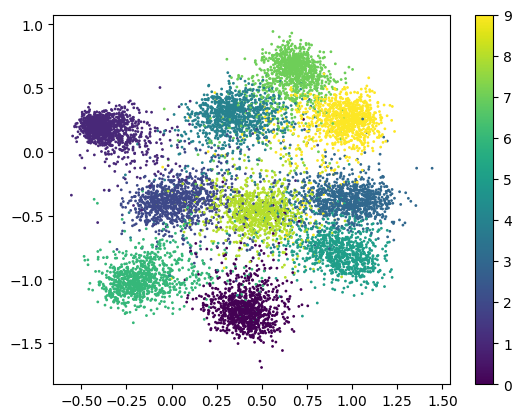

In [13]:
f = cnn.predict(X_test/255.)
p = plt.scatter(f[:,0],f[:,1],c=y_test,s=1)
plt.colorbar(p)

**Save model**

In [14]:
cnn.save('cnn_loss1.h5')

**Load model and test**

313/313 [==============================] - 1s 4ms/step


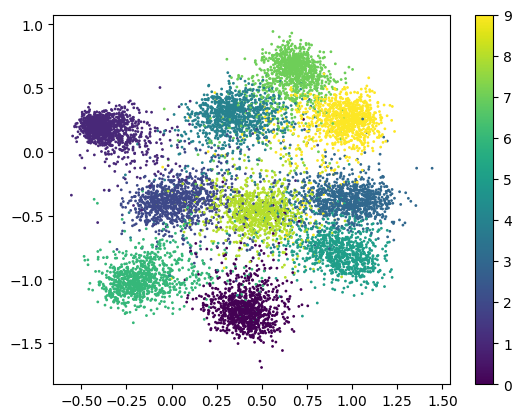

In [15]:
from tensorflow.keras.models import load_model
m = load_model('cnn_loss1.h5')

f1 = m.predict(X_test/255.)
p=plt.scatter(f1[:,0],f1[:,1],c=y_test,s=1)
plt.colorbar(p)

**Visualize negative distance and positive distance**

In [17]:
i = 0 
y_true = []
y_pred = []
for pair,y in generator(X_test,y_test):
  f1 = cnn(pair[0])
  f2 = cnn(pair[1])
  d = np.sqrt(np.sum((f1-f2)**2,axis=1,keepdims=True))
  y_pred += list(d.ravel())
  y_true += list(y)
  i += 1
  if i>500:
    break

**Plot Histogram**

(array([3.55862213e-02, 1.14369590e-01, 2.70907824e-01, 4.70437620e-01,
        6.80457753e-01, 8.69702779e-01, 8.78753180e-01, 8.46458594e-01,
        8.37613050e-01, 7.97707516e-01, 6.56802501e-01, 5.02732638e-01,
        4.41433380e-01, 3.41257547e-01, 2.45195296e-01, 1.48310242e-01,
        7.79605850e-02, 2.55068682e-02, 2.67411240e-03, 6.17101649e-04]),
 array([0.01755283, 0.13884604, 0.26013926, 0.38143247, 0.50272566,
        0.62401891, 0.74531209, 0.86660534, 0.98789853, 1.10919178,
        1.23048496, 1.35177815, 1.47307134, 1.59436464, 1.71565783,
        1.83695102, 1.9582442 , 2.07953739, 2.2008307 , 2.32212377,
        2.44341707]),
 <BarContainer object of 20 artists>)

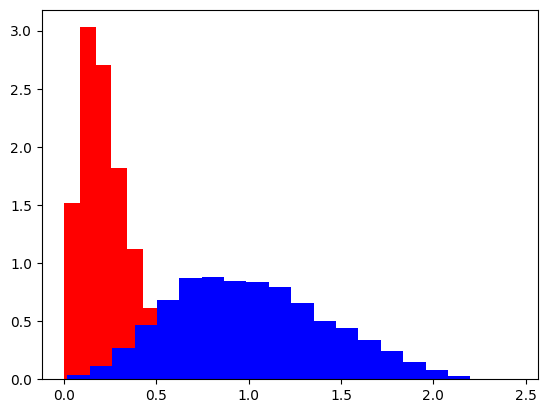

In [18]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

positive_distances = y_pred[y_true == 1]
negative_distances = y_pred[y_true == 0]

plt.hist(positive_distances,color='r',density=True,bins=20)
plt.hist(negative_distances,color='b',density=True,bins=20)

**Check report using sklearn**

In [20]:
thresh = 0.5 
y_pred_ = y_pred < thresh 
y_pred_.astype('uint8')
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred_))

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     40080
         1.0       0.90      0.91      0.90     40080

    accuracy                           0.90     80160
   macro avg       0.90      0.90      0.90     80160
weighted avg       0.90      0.90      0.90     80160

